In [424]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import *
from scipy import special

import math

import sys
sys.setrecursionlimit(10000)

D = Decimal


## Izracun $f(x)$ in $g(x)$


### Kaj sm naredu

1. Prvo kot prvo, verjetno je bols zmnozit sele nakonc z 1/3. -> PREVER, mogoce pa ne
2. Poisc f_k z rekurzijo, brez fakultet ker te cist zjebe numericno. To nardis z $f_{k+1} = GOODNOTES$


In [425]:
getcontext().prec = 115

alpha = D(0.355028053887817239)
beta = D(0.258819403792806798)


In [426]:
alpha

Decimal('0.355028053887817218736699942382983863353729248046875')

In [427]:
# x and sum have to be Decimal dtype
def A_B_i(x, max_sum_steps, min_precision):
    x = D(float(x))
    
    precision = D(10)**(-min_precision)
    precise = False

    sum_A_i = D(0)
    sum_B_i = D(0)
    k = D(1)
    # pri k = 0 je 1
    f_k = D(1)
    g_k = D(x)

    sum_A_i, sum_B_i, delta_sum_A_i, delta_sum_B_i = [D(0)]*4

    while k < max_sum_steps and not precise:
        delta_sum_A_i = alpha * f_k - beta * g_k
        delta_sum_B_i = D(3).sqrt() * (alpha*f_k + beta*g_k)

        if delta_sum_A_i.__abs__().compare(precision) < D(1) and delta_sum_B_i.__abs__().compare(precision) < D(1):
            precise = True
            break

        sum_A_i += delta_sum_A_i
        sum_B_i += delta_sum_B_i

        f_k *= (x**3 * (D(1) - D(2) / D(3) / k)) / (D(3)*k-D(1)) / (D(3)*k - D(2))
        g_k *= (x**3 * (D(1) - D(1) / D(3) / k)) / (D(3)*k+D(1)) / (D(3)*k - D(1))

        k += D(1)
    
    # print(k, delta_sum_A_i, precision, delta_sum_A_i.compare(precision))
    # print(k, delta_sum_B_i, precision, delta_sum_A_i.compare(precision))

    return sum_A_i,  sum_B_i, k



A_B_i = np.vectorize(A_B_i)


In [428]:
A_B_i(D(0),D(1000), 10)

(array(Decimal('0.3550280538878172187366999424'), dtype=object),
 array(Decimal('0.6149266274460006996034144892'), dtype=object),
 array(Decimal('2'), dtype=object))

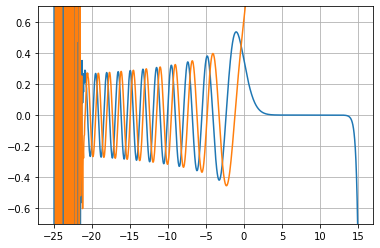

In [429]:
x = np.linspace(-25,15,1000,dtype=Decimal)

A_i, B_i, k = A_B_i(x, D(100000), 10)

plt.plot(x, A_i)
plt.plot(x, B_i)

plt.ylim([-0.7,0.7])

plt.grid()
plt.show()

# print(k)


Asimptotska

Ideje:
- sinus dobimo najbols z x = x % (2 $\pi$)

In [430]:
def primitive_u_s(s):
    return special.gamma(3*s + 1/2) / (52**s * special.factorial(s) * special.gamma(s+1/2))

In [431]:
def memoize(func):
    cache = dict()

    def memoized_func(*args):
        if args in cache:
            return cache[args]
        result = func(*args)
        cache[args] = result
        return result

    return memoized_func

In [432]:
def u_s(s):
    if s == 0:
        return 1
    
    return u_s(s-1) * (D(s)-D(5)/D(6)) * (D(1) - D(1) / D(6) / D(s))

u_s = memoize(u_s)

Sam neka primerjava med u_s in primitivno implementacijo

In [433]:
u_s(2), primitive_u_s(2)

(Decimal('0.1485339506172839506172839507'), 0.040044840976331354)

Zdej pa gremo na funkcije

In [434]:
def L(x, max_steps):
    sum = 0
    s = 0
    while s < max_steps:
        delta_sum = u_s(s) / D(x).__pow__(D(s))
        sum += delta_sum
        s += 1
    return sum

def min_plus_k(k):
    if k % 2 == 0:
        return 1
    return -1


def P(x, max_steps):
    sum = 0
    s = 0
    while s < max_steps:
        delta_sum = min_plus_k(s) * u_s(2*s+1) / D(x).__pow__(D(2*s+1))
        sum += delta_sum
        s += 1
    return sum


def Q(x, max_steps):
    sum = 0
    s = 0
    while s < max_steps:
        delta_sum = min_plus_k(s) * u_s(2*s) / D(x).__pow__(D(2*s))
        sum += delta_sum
        s += 1
    return sum

def A_i_big_x(x, maxSteps = 1000):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))
    steps = 5
    Ai = D(0)
    # new_Ai = D(0)
    previousDelta = D('inf')

    while steps < maxSteps:
        new_Ai = (D(-ksi).exp())/(D(2) * D(math.pi).sqrt()
                         * D(x).__pow__(D(0.25))) * L(-ksi, steps)

        new_delta = D(new_Ai - Ai).__abs__()

        if new_delta > previousDelta:
            break

        previousDelta = new_delta
        Ai = new_Ai

        steps += 1

    # print(steps)
    return Ai


def B_i_big_x(x, maxSteps=1000):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))
    steps = 5
    Bi = D(0)
    # new_Ai = D(0)
    previousDelta = D('inf')

    while steps < maxSteps:
        new_Bi = (D(ksi).exp())/(D(math.pi).sqrt() * D(x).__pow__(D(0.25))) * L(ksi, steps)

        new_delta = D(new_Bi - Bi).__abs__()

        if new_delta > previousDelta:
            break

        previousDelta = new_delta
        Bi = new_Bi

        steps += 1

    # print(steps)
    return Bi


In [435]:
# L(0.5, 12)
# P(0.5, 50)
# min_plus_k(2)
# Q(0.5, 100)

In [436]:
def relative_diff(t):
    return D((A_B_i(D(t), D(1000), 50)[0] - A_i_big_x(t))/A_i_big_x(t)).__abs__()

relative_diff = np.vectorize(relative_diff)

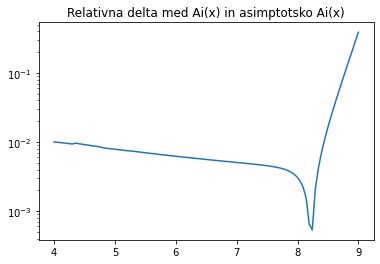

In [437]:
# t = 7
t = np.linspace(4,9,100)

y = relative_diff(t)

# (A_B_i(D(t), D(1000), 10)[1] - B_i_big_x(t)) / B_i_big_x(t)
# (A_B_i(D(t), D(1000), 50)[0] - A_i_big_x(t))/A_i_big_x(t)

plt.title('Relativna delta med Ai(x) in asimptotsko Ai(x)')

plt.plot(t,y)
plt.yscale('log')
# plt.


Zdej gremo se za negativne k mamo use herlper functione

In [466]:
def Ai_negativni_x(x, maxSteps=1000):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))

    ksi_reduced = ksi % (D(2*math.pi))
    steps = 5
    Ai = D(0)
    # new_Ai = D(0)
    previousDelta = D('inf')

    while steps < maxSteps:
        new_Ai = (1)/(D(math.pi).sqrt() * D(-x).__pow__(D(0.25))) * (D(math.sin(ksi_reduced + D(math.pi / 4)))
                                                                     * Q(ksi, steps) + D(math.cos(ksi_reduced + D(math.pi / 4))) * P(ksi, steps))

        new_delta = D(new_Ai - Ai).__abs__()

        if new_delta > previousDelta:
            break

        previousDelta = new_delta
        Ai = new_Ai

        steps += 1

    # print(steps)
    return Ai


def Bi_negativni_x(x, maxSteps=1000):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))

    ksi_reduced = ksi % (D(2*math.pi))
    steps = 5
    Bi = D(0)
    # new_Ai = D(0)
    previousDelta = D('inf')

    while steps < maxSteps:
        new_Bi = (1)/(D(math.pi).sqrt() * D(-x).__pow__(D(0.25))) * (D(-math.sin(ksi_reduced + D(math.pi / 4)))
                                                                     * P(ksi, steps) + D(math.cos(ksi_reduced + D(math.pi / 4))) * Q(ksi, steps))

        new_delta = D(new_Bi - Bi).__abs__()

        if new_delta > previousDelta:
            break

        previousDelta = new_delta
        Bi = new_Bi

        steps += 1

    # print(steps)
    return Bi


Ai_negativni_x = np.vectorize(Ai_negativni_x)
Bi_negativni_x = np.vectorize(Bi_negativni_x)


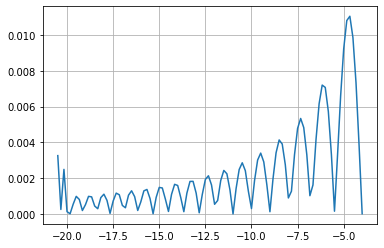

In [482]:
t = np.linspace(-20.5, -4, 100)

A_i, B_i, k = A_B_i(t, D(100000), 10)

# Ai_asimptotika = Ai_negativni_x(t)
Bi_asimptotika = Bi_negativni_x(t)

# plt.plot(t, A_i)
# plt.plot(t, B_i)
# plt.plot(t, Ai_asimptotika)
# plt.plot(t, Bi_asimptotika)

plt.plot(t, np.abs(B_i - Bi_asimptotika))


# plt.ylim([-0.7, 0.7])

plt.grid()
plt.show()



Iskanje nicel